Only for when running from local notebooks:

In [1]:
import sys
sys.path.append('C:\\Users\\Yonatan Gideoni\\Desktop\\ML4Q\\c3')

Mostly copied from <code>single_qubit_experiment.py</code>  
Imports:

In [2]:
import copy
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from c3.model import Model as Mdl
from c3.c3objs import Quantity as Qty
from c3.parametermap import ParameterMap as PMap
from c3.experiment import Experiment as Exp
from c3.generator.generator import Generator as Gnr
import c3.signal.gates as gates
import c3.libraries.chip as chip
import c3.generator.devices as devices
import c3.libraries.hamiltonians as hamiltonians
import c3.signal.pulse as pulse
import c3.libraries.envelopes as envelopes

Constants:

In [3]:
dressed = True
qubit_lvls = 3
freq = 5.001234e9  # [Hz]
anhar = -209.8765e6  # [Hz]
qubit_temp = 0  #[K]
t_final = 7e-9  # Time for single qubit gates
sim_res = 100e9  # [Hz]
awg_res = 2e9  # [Hz]
sideband = 50e6  # [Hz]
lo_freq = 5e9 + sideband  # [Hz]

Set up the model:

In [4]:
q1 = chip.Qubit(
    name="Q1",
    desc="Qubit 1",
    freq=Qty(
        value=freq,
        min_val=4.995e9,  # very localized
        max_val=5.005e9,
        unit="Hz 2pi",
    ),
    anhar=Qty(
        value=anhar,
        min_val=-380e6,
        max_val=-120e6,  # very general - min/max because of temperature fluctuations?
        unit="Hz 2pi",
    ),
    hilbert_dim=qubit_lvls,
    temp=Qty(value=qubit_temp, min_val=0.0, max_val=0.12, unit="K"),
)

drive = chip.Drive(
    name="d1",
    desc="Drive 1",
    comment="Drive line 1 on qubit 1",
    connected=["Q1"],
    hamiltonian_func=hamiltonians.x_drive,  # position coordinate hamiltonian, still need to understand
)
phys_components = [q1]
line_components = [drive]

model = Mdl(phys_components, line_components)
model.set_dressed(dressed)  # need to understand difference between being on/off - what are the eigenstates if it's off?

# Generator 
Converts digital signal to physical signal that arrives on the chip via various devices:

In [5]:
generator = Gnr(
    devices={
        "LO": devices.LO(name="lo", resolution=sim_res, outputs=1),  # local oscillator
        "AWG": devices.AWG(name="awg", resolution=awg_res, outputs=1),  # arbitrary wave generator
        "DigitalToAnalog": devices.DigitalToAnalog(
            name="dac", resolution=sim_res, inputs=1, outputs=1
        ),
        "Mixer": devices.Mixer(name="mixer", inputs=2, outputs=1),
        "VoltsToHertz": devices.VoltsToHertz(
            name="v_to_hz",
            V_to_Hz=Qty(value=1e9, min_val=0.9e9, max_val=1.1e9, unit="Hz/V"),
            inputs=1,
            outputs=1,
        ),
    },
    chains={
        "d1": {
            "LO": [],
            "AWG": [],
            "DigitalToAnalog": ["AWG"],
            "Mixer": ["LO", "DigitalToAnalog"],
            "VoltsToHertz": ["Mixer"],
        }
    },
)

Sketch:
<div>
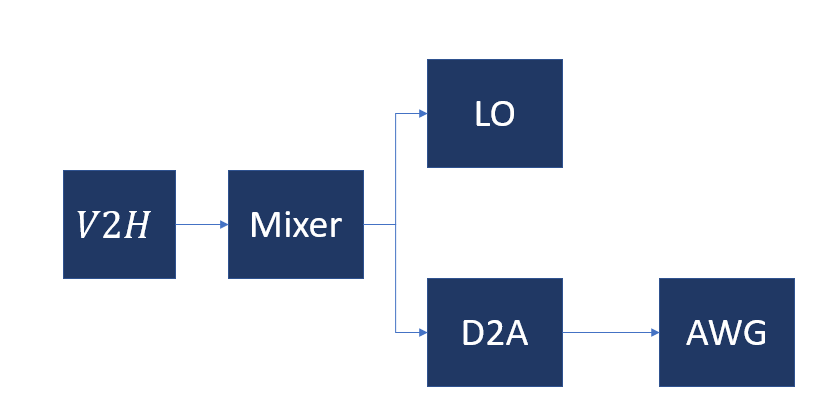
</div>
Need to understand how the signal is recombined...

Gateset - set of gates that will be applied one after the other.

In [6]:
gauss_params_single = {
    "amp": Qty(value=0.45, min_val=0.35, max_val=0.6, unit="V"),
    "t_final": Qty(
        value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
    ),
    "sigma": Qty(
        value=t_final / 4, min_val=t_final / 8, max_val=t_final / 2, unit="s"
    ),
    "xy_angle": Qty(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Qty(
        value=-sideband - 0.5e6,
        min_val=-60 * 1e6,
        max_val=-40 * 1e6,
        unit="Hz 2pi",
    ),
    "delta": Qty(value=-1, min_val=-5, max_val=3, unit=""),
}
blackman_params_single = {
    "amp": Qty(value=0.45, min_val=0.35, max_val=0.6, unit="V"),
    "t_final": Qty(
        value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
    ),
    "xy_angle": Qty(
        value=0.0, min_val=-0.5 * np.pi, max_val=2.5 * np.pi, unit="rad"
    ),
    "freq_offset": Qty(
        value=-sideband - 0.5e6,
        min_val=-60 * 1e6,
        max_val=-40 * 1e6,
        unit="Hz 2pi",
    ),
    "delta": Qty(value=-1, min_val=-5, max_val=3, unit=""),
}

In [8]:
gauss_env_single = pulse.EnvelopeDrag(
    name="gauss",
    desc="Gaussian comp for single-qubit gates",
    params=gauss_params_single,
    shape=envelopes.gaussian_nonorm,
)
blackman_env_single = pulse.EnvelopeDrag(
    name="blackman",
    desc="Blackman comp for single-qubit gates",
    params=blackman_params_single,
    shape=envelopes.blackman_window,
)
nodrive_env = pulse.Envelope(
    name="no_drive",
    params={
        "t_final": Qty(
            value=t_final, min_val=0.5 * t_final, max_val=1.5 * t_final, unit="s"
        )
    },
    shape=envelopes.no_drive,
)

In [9]:
carrier_parameters = {
    "freq": Qty(
        value=lo_freq,
        min_val=4.5e9,
        max_val=6e9,
        unit="Hz 2pi",
    ),
    "framechange": Qty(value=0.0, min_val=-np.pi, max_val=3 * np.pi, unit="rad"),
}
carr = pulse.Carrier(
    name="carrier",
    desc="Frequency of the local oscillator",
    params=carrier_parameters,
)

In [10]:
rx90p = gates.Instruction(
    name="rx90p", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)
QId = gates.Instruction(
    name="id", t_start=0.0, t_end=t_final, channels=["d1"], targets=[0]
)

rx90p.add_component(gauss_env_single, "d1")
rx90p.add_component(carr, "d1")
QId.add_component(nodrive_env, "d1")
QId.add_component(copy.deepcopy(carr), "d1")
QId.comps["d1"]["carrier"].params["framechange"].set_value(
    (-sideband * t_final) % (2 * np.pi)
)

parameter_map = PMap(
    instructions=[QId, rx90p], model=model, generator=generator
)

Create and simulate experiment:

In [11]:
exp = Exp(pmap=parameter_map)

In [12]:
exp.compute_propagators();

In [13]:
psi_init = [[0] * qubit_lvls]
psi_init[0][0] = 1
init_state = tf.transpose(tf.constant(psi_init, tf.complex128))

In [14]:
def plot_dynamics(exp, psi_init, seq, goal=-1):
        """
        Plotting code for time-resolved populations.

        Parameters
        ----------
        psi_init: tf.Tensor
            Initial state or density matrix.
        seq: list
            List of operations to apply to the initial state.
        goal: tf.float64
            Value of the goal function, if used.
        debug: boolean
            If true, return a matplotlib figure instead of saving.
        """
        model = exp.pmap.model
        dUs = exp.partial_propagators
        psi_t = psi_init.numpy()
        pop_t = exp.populations(psi_t, model.lindbladian)
        for gate in seq:
            for du in dUs[gate]:
                psi_t = np.matmul(du.numpy(), psi_t)
                pops = exp.populations(psi_t, model.lindbladian)
                pop_t = np.append(pop_t, pops, axis=1)

        fig, axs = plt.subplots(1, 1)
        ts = exp.ts
        dt = ts[1] - ts[0]
        ts = np.linspace(0.0, dt*pop_t.shape[1], pop_t.shape[1])
        axs.plot(ts / 1e-9, pop_t.T)
        axs.grid(linestyle="--")
        axs.tick_params(
            direction="in", left=True, right=True, top=True, bottom=True
        )
        axs.set_xlabel('Time [ns]')
        axs.set_ylabel('Population')
        plt.legend(model.state_labels)
        
        plt.xlim(0)
        plt.ylim(0.0)

<IPython.core.display.Javascript object>


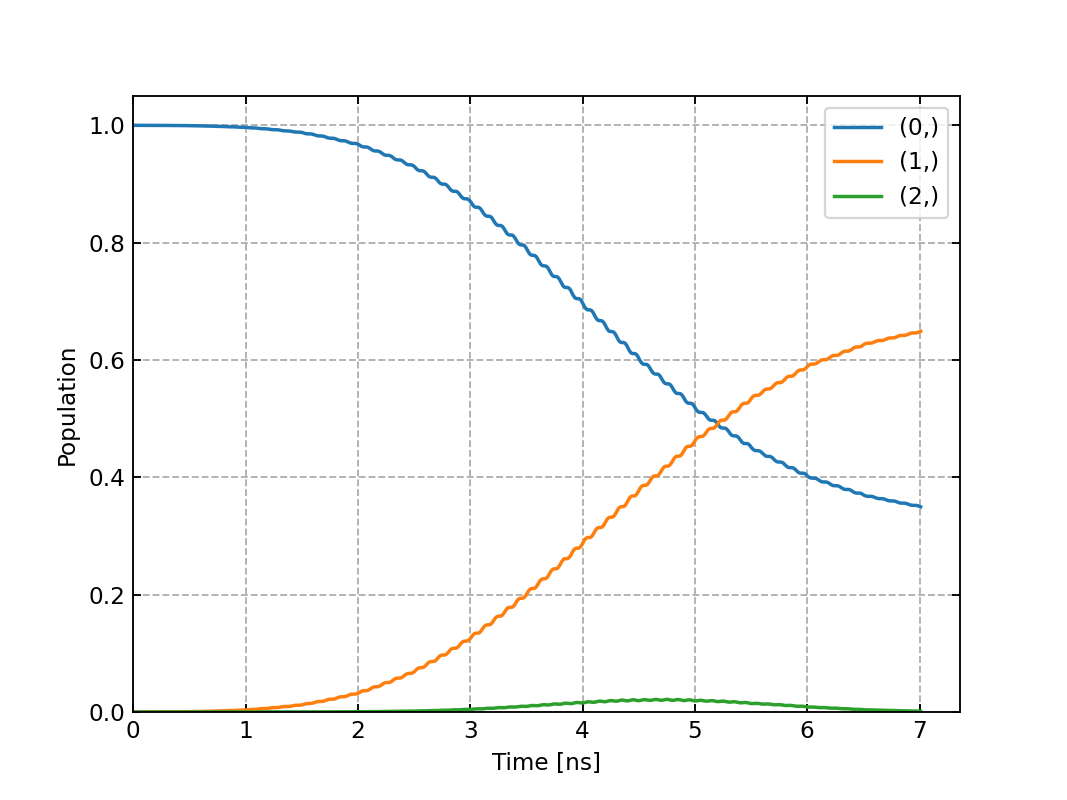

In [15]:
%matplotlib notebook

seq = ['rx90p[0]']
plot_dynamics(exp, init_state, seq)

Plot signal:

<IPython.core.display.Javascript object>


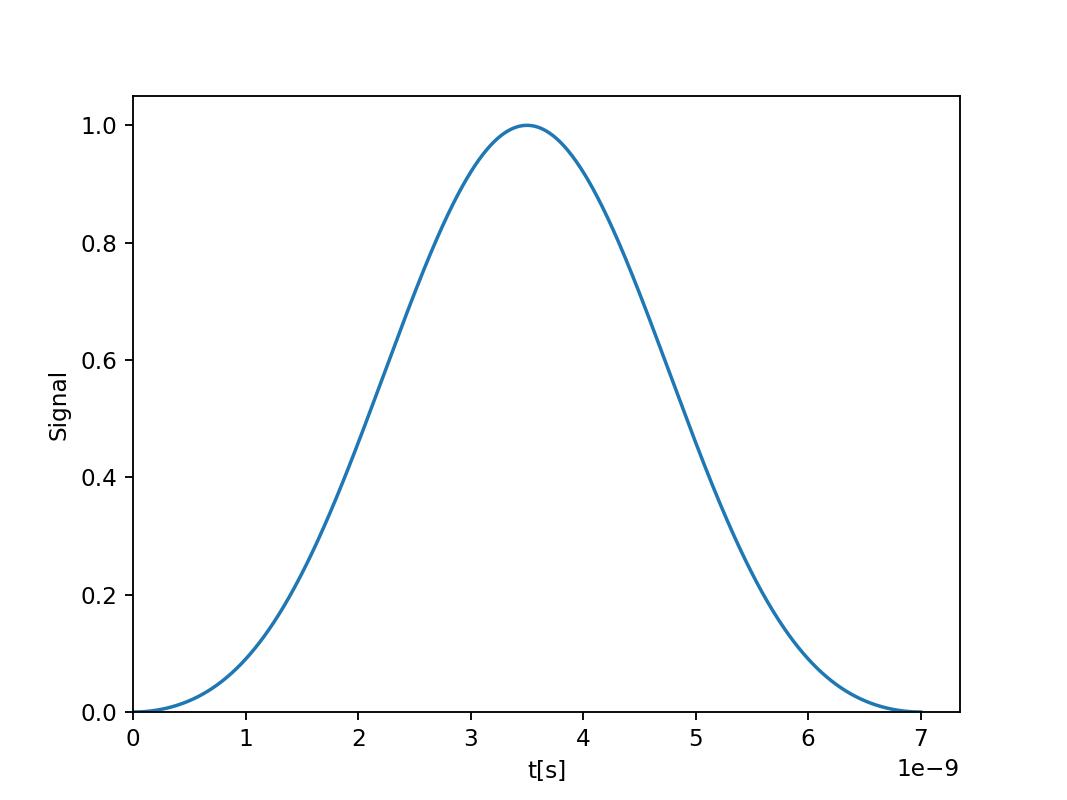

Text(0, 0.5, 'Signal')

In [37]:
t = np.linspace(0, t_final, num=10**3)

signal = np.array(blackman_env_single.shape(t, blackman_params_single)).real

plt.plot(t, signal)
plt.xlim(0)
plt.ylim(0)
plt.xlabel('t[s]')
plt.ylabel('Signal')